In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import itertools
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import spacy
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import re
import nltk
import collections
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
import scipy.sparse as sp

Using TensorFlow backend.


In [7]:
#Loading the first dataset
df = pd.read_csv(r'C:\Users\ojas\Desktop\Project Final Year\Dataset\data.csv')
df.loc[df['Label']== 0, 'Label'] = 'REAL'
df.loc[df['Label']== 1, 'Label'] = 'FAKE'
df.columns
df['Label'].value_counts()
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE


In [8]:
#Dropping the column URLs from the table
df = df[['Headline', 'Body', 'Label']]
df.columns = ['Headline', 'Body', 'Label']
df['Label'].value_counts()

REAL    2137
FAKE    1872
Name: Label, dtype: int64

In [9]:
#Loading the 2nd dataset
df1 = pd.read_csv(r'C:\Users\ojas\Desktop\Project Final Year\Dataset\fake.csv')
df1.columns
df1['type'].value_counts()
df1 = df1.loc[df1['type']=='fake']
df1.loc[df1['type']== 'fake', 'type'] = 'FAKE'
df1.columns

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')

In [10]:
#Selecting the 3 required columns and remvoing the rest.
df1 = df1[['title','text','type']]
df1.columns = ['Headline', 'Body', 'Label']
df1['Label'].value_counts()

FAKE    19
Name: Label, dtype: int64

In [11]:
#Loading the 3rd dataset.
df2 = pd.read_csv(r'C:\Users\ojas\Desktop\Project Final Year\Dataset\fake_or_real_news.csv')
df2.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [12]:
#Selecting the 3 required columns and remvoing the rest.
df2 = df2[['title','text','label']]
df2.columns = ['Headline', 'Body', 'Label']
df2['Label'].value_counts()

REAL    3171
FAKE    3164
Name: Label, dtype: int64

In [13]:
#Loading the 4th dataset.
df3 = pd.read_csv(r'C:\Users\ojas\Desktop\Project Final Year\Dataset\train.csv')
df3.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [14]:
#Selecting the 3 required columns and remvoing the rest.
df3 = df3[['title','text','label']]
df3.columns = ['Headline', 'Body', 'Label']
df3.loc[df3['Label']== 0, 'Label'] = 'REAL'
df3.loc[df3['Label']== 1, 'Label'] = 'FAKE'
df3.columns
df3['Label'].value_counts()

FAKE    10413
REAL    10387
Name: Label, dtype: int64

In [15]:
#Appending df1,df2,df3 to df so that we can get a bigger dataset which will eventually improve our model.
df = df.append(df1, ignore_index = True)
df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

In [16]:
#Removing the duplicate news and the news with SMALL body because they will degrade the performance of our models.
df = df.drop_duplicates()
cnt = 0
ind = []
for art in df['Body']:
    if len(str(art)) < 10:
        ind.append(cnt)
    cnt+=1
df = df.drop(df.index[ind])
df

,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE
...,...,...,...
31157,Trump: Putin ’Very Smart’ to Not Retaliate ove...,Donald Trump took to Twitter Friday to praise ...,REAL
31158,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,REAL
31159,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,REAL
31160,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,REAL


In [17]:
#Total classified records in our dataset
df['Label'].value_counts()

REAL    15343
FAKE    12522
Name: Label, dtype: int64

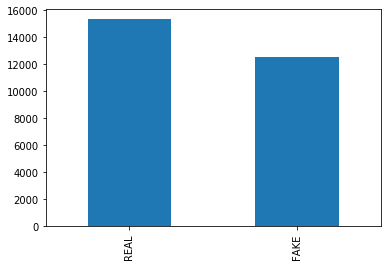

In [18]:
#Bar graph
df['Label'].value_counts().plot(kind = 'bar')

In [19]:
#Calculating headline length and its other statistics.
df['headline_length'] = [len(str(a)) for a in df['Headline']]
df['headline_length'].describe()

count    27865.000000
mean        69.775381
std         24.885773
min          1.000000
25%         55.000000
50%         70.000000
75%         85.000000
max        653.000000
Name: headline_length, dtype: float64

In [20]:
#Calculating body length and its other statistics.
df['body_length'] = [len(a) for a in df['Body']]
df['body_length'].describe()

count     27865.000000
mean       4429.890903
std        4854.862554
min          10.000000
25%        1589.000000
50%        3348.000000
75%        6106.000000
max      142961.000000
Name: body_length, dtype: float64

In [21]:
df.head()

,Headline,Body,Label,headline_length,body_length
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE,42,6412
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE,66,3325
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE,60,6580
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE,68,630
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE,43,213


In [22]:
#Merging HEADLINE and BODY column to make it a single feature to train our model.
df["Text"] = df["Headline"].map(str) + df["Body"]
y = df.Label
y = y.astype('str')

In [23]:
#Creating the TESTING DATASET and TRAINING DATASET.
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'],y, test_size=0.33)

In [24]:
X_train.head()

6639     Mitch McConnell's mission to keep the GOP majo...
19302    VIDEO : Ann Coulter Gloats About Being Right W...
21776    Samantha Bee: Who Gives A F**K About Trump, Th...
22519    Report: Saudis Quietly Backing UN Peace Plan f...
1447     VW to develop electric trucks in $1.7 billion ...
Name: Text, dtype: object

In [25]:
#Tf-idf Bigrams
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2))

# Fit and transform the training data 
tfidf1_train = tfidf_vectorizer.fit_transform(X_train.astype('str')) 

# Transform the test set 
tfidf1_test = tfidf_vectorizer.transform(X_test.astype('str'))

#We use pickle so that we cana again use the model without running it again. Pickle stores the model
#in memory which can be used later. Need to be used once to create and store the model.

pickle.dump(tfidf1_train, open("tfidf1_train.pickle", "wb"))
pickle.dump(tfidf1_test, open("tfidf1_test.pickle", "wb"))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer","wb"))

In [26]:
print(type(tfidf1_train)) #The data structure used for storing vectors in tfidfvectorizer is
                          #Compressed sparse matrix to reduce memory usage.

<class 'scipy.sparse.csr.csr_matrix'>


In [27]:
#Top 10 tfidf bigrams
tfidf_vectorizer.get_feature_names()[-10:]

['鉴于当代挑战和威胁的全球性质 要制定采取有效对策所需的集体办法',
 '集体安全条约组织 上海合作组织和独立国家联合体',
 '集体安全条约组织与联合国专门机构 包括安全理事会反恐怖主义委员会和联合国毒品和犯罪问题办公室',
 '集体安全条约组织是多层面结构 能对其成员国可能面临的当代广泛的挑战和威胁作出坚定回应',
 '集体安全条约组织正在积极促进帮助阿富汗进行冲突后重建以及消除来自该国的毒品威胁的国际努力 该组织与联合国的关系在许多领域都得到成功的发展',
 '集体安全条约组织秘书长博尔久扎 上海合作组织秘书长阿利莫夫以及独联体执行委员会副主席伊凡诺夫将发表讲话',
 '集体提出创新办法 嗣后可推广到安全理事会重点关注的世界其他地区',
 '非法贩运毒品以及确保国际信息安全 在此范畴内',
 '预防和解决冲突 反恐',
 'ﬁnds emotion']

In [28]:
#Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0, 1], classes, rotation=45)
    plt.yticks([-0.5, 1.5], classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
clf_MNB = MultinomialNB()
clf_MNB.fit(tfidf1_train, Y_train)
pickle.dump(clf_MNB, open('tfidf_nb','wb'))
pred = clf_MNB.predict(tfidf1_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy with MultinomialNB:   %0.3f" % score)  


Accuracy with MultinomialNB:   0.826


Confusion matrix


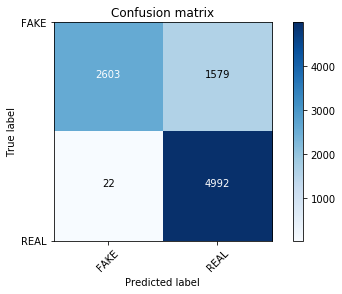

In [30]:
cm = metrics.confusion_matrix(Y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [31]:
clf_RFC = RandomForestClassifier()
clf_RFC.fit(tfidf1_train, Y_train)
pickle.dump(clf_RFC, open('tfidf_rf', 'wb'))
pred = clf_RFC.predict(tfidf1_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

C:\Users\ojas\Anaconda3\Lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with RandomForestClassifier:   0.890


In [32]:
print(tfidf1_test.shape)

(9196, 4027725)


Confusion matrix


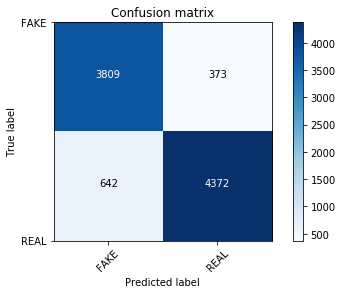

In [33]:
cm = metrics.confusion_matrix(Y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [34]:
clf_GBC = GradientBoostingClassifier()
clf_GBC.fit(tfidf1_train, Y_train)
pickle.dump(clf_GBC, open('tfidf_gb', 'wb'))
pred = clf_GBC.predict(tfidf1_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Accuracy with Gradient Boosting:   0.856


Confusion matrix


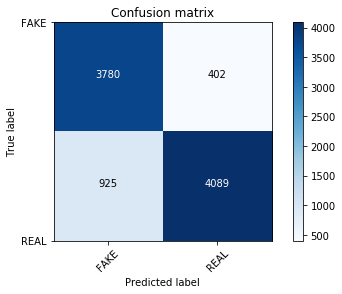

In [35]:
cm = metrics.confusion_matrix(Y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [36]:
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(tfidf1_train, Y_train)
pickle.dump(clf_svm, open('tfidf_svc', 'wb'))
pred = clf_svm.predict(tfidf1_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy with SVC:   %0.3f" % score)

Accuracy with SVC:   0.939


Confusion matrix


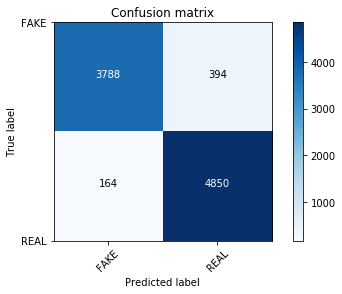

In [37]:
cm = metrics.confusion_matrix(Y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

RandomForestClassifier
________________________________________________________________________________
Training: RandomForestClassifier


C:\Users\ojas\Anaconda3\Lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 58.294s
test time:  1.117s
accuracy:   0.884

Naive Bayes
________________________________________________________________________________
Training: Naive Bayes
train time: 0.504s
test time:  0.119s
accuracy:   0.825

GradientBoosting
________________________________________________________________________________
Training: GradientBoosting
train time: 969.108s
test time:  0.163s
accuracy:   0.849

SVC
________________________________________________________________________________
Training: SVC
train time: 3096.760s
test time:  358.090s
accuracy:   0.940



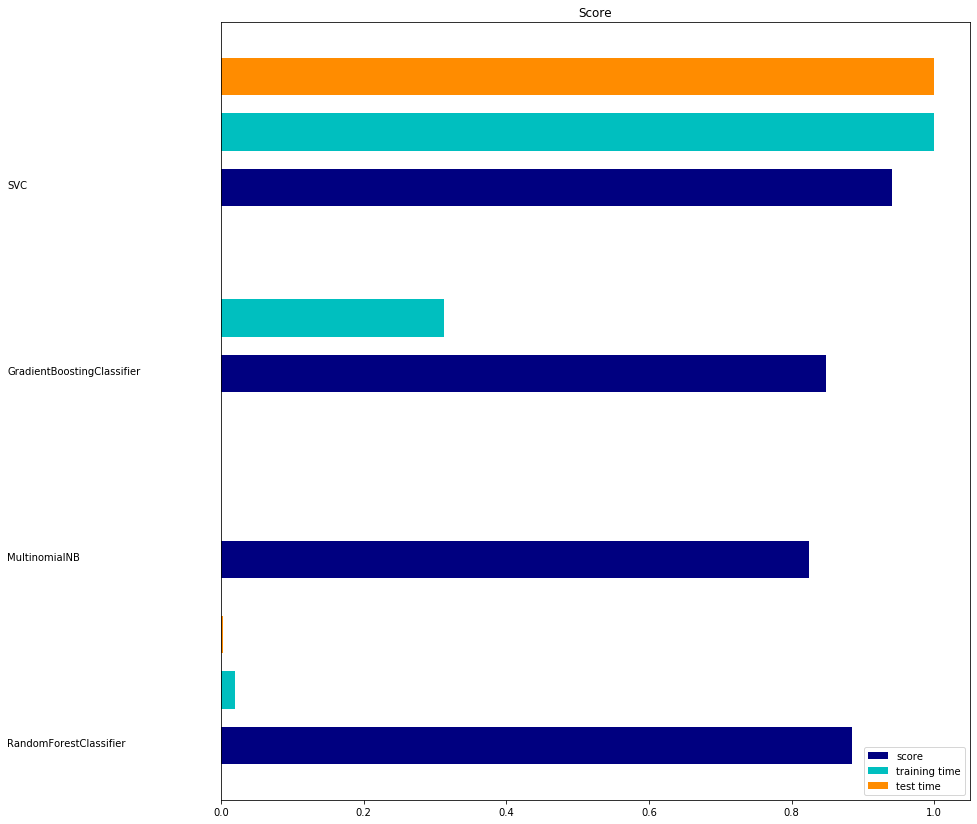

In [33]:
import logging
import sys
from time import time
def benchmark(clf,name):
    print('_' * 80)
    print("Training: "+name)
    t0 = time()
    clf.fit(tfidf1_train, Y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(tfidf1_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(Y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []

# Train Random Forest Classifier
print('=' * 80)
print("RandomForestClassifier")
results.append(benchmark(RandomForestClassifier(),"RandomForestClassifier"))

# Train Naive Bayes classifier
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(),"Naive Bayes"))

# Train GradientBoosting Classifier
print('=' * 80)
print("GradientBoosting")
results.append(benchmark(GradientBoostingClassifier(),"GradientBoosting"))

# Train SVC Classifier
print('=' * 80)
print("SVC")
results.append(benchmark(svm.SVC(kernel='linear'),"SVC"))

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(16, 12))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

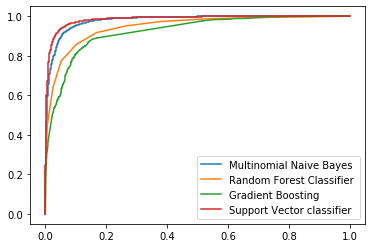

In [36]:
plt.figure(0).clf()

for model, name in [(clf_MNB, 'Multinomial Naive Bayes '),
                    (clf_RFC,'Random Forest Classifier'),(clf_GBC,'Gradient Boosting'),(clf_svm, 'Support Vector classifier')
                     ]:
    if name == 'Support Vector classifier':
        pred = model.decision_function(tfidf1_test)
    else:
        pred = model.predict_proba(tfidf1_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(Y_test.values, pred, pos_label='REAL')
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)

In [34]:
#Predicting using SVM.
st = pd.Series(["Kayne West wins presidential elections."])
my_headline = tfidf_vectorizer.transform(st.astype('str'))
my_pred = clf_MNB.predict(my_headline)
print(my_pred)
for i in my_pred:
    s = str(i)
print(s)

['FAKE']
FAKE


In [63]:
#Testing Spacy
nlp = spacy.load('en_core_web_sm')
txt = ('hi! This is Ojas.')
doc = nlp(txt)
print([token.text for token in doc])

['hi', '!', 'This', 'is', 'Ojas', '.']


In [ ]:
#Generating the POS tags for all the articles and adding a new column by replacing text with their POS tags
nlp = spacy.load('en_core_web_sm')
x = []
df["Text"] = df["Headline"].map(str) + df["Body"]
for txt in df['Text']:
    text_new = []
    doc = nlp(str(txt))
    for token in doc:
        text_new.append(token.pos_)
    Txt = ' '.join(text_new)
    x.append(Txt)
df['Text_pos'] = x
df.to_pickle('newdata.pkl')

In [38]:
df = pd.read_pickle('newdata.pkl')
cnt = 0
ind = []
for article in df['Body']:
    if len(str(article)) < 10:
        ind.append(cnt)
    cnt+=1
df = df.drop(df.index[ind])

In [39]:
y = df.Label
y = y.astype('str')
x_train, x_test, y_train, y_test = train_test_split(df['Text_pos'],y, test_size=0.33)
x_train

14388    PROPN PROPN PUNCT PRON AUX NOUN ADP DET NOUN A...
12449    PROPN PROPN VERB ADP PROPN ADP PUNCT NUM PROPN...
6273     PROPN PART NOUN PUNCT PUNCT DET NOUN ADP NOUN ...
5017     PROPN NOUN VERB ADP PUNCT NOUN NOUN PROPN NOUN...
24998    PROPN PROPN CCONJ PROPN PROPN PART PROPN PUNCT...
                               ...                        
7311     NOUN PUNCT PROPN CCONJ ADJ NOUN ADV PROPN ADP ...
26840    PROPN PROPN ADP PUNCT PROPN PUNCT AUX VERB ADP...
30922    ADP PROPN PROPN PART NOUN PUNCT PROPN PROPN VE...
27436    DET PROPN ADP PROPN PROPN PROPN PROPN ADP PROP...
19773    PROPN PROPN PROPN PROPN PROPN PROPN PART PROPN...
Name: Text_pos, Length: 20755, dtype: object

In [40]:
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer_pos = TfidfVectorizer(stop_words='english', ngram_range = (2,2)) 
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer_pos.fit_transform(x_train.astype('str')) 
# Transform the test set 
tfidf_test = tfidf_vectorizer_pos.transform(x_test.astype('str'))

#We use pickle so that we cana again use the model without running it again. Pickle stores the model
#in memory which can be used later.

pickle.dump(tfidf_train, open("tfidf_train.pickle", "wb"))
pickle.dump(tfidf_test, open("tfidf_test.pickle", "wb"))
pickle.dump(tfidf_vectorizer_pos, open("tfidf_vectorizer_pos.pickle","wb"))

In [41]:
tfidf_vectorizer_pos.get_feature_names()[-10:]

['verb intj',
 'verb noun',
 'verb num',
 'verb pron',
 'verb propn',
 'verb punct',
 'verb sconj',
 'verb space',
 'verb sym',
 'verb verb']

In [42]:
clf_MNB_pos = MultinomialNB()
clf_MNB_pos.fit(tfidf_train, y_train)
pickle.dump(clf_MNB_pos, open('pos_nb', 'wb'))
pred = clf_MNB_pos.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.787


Confusion matrix


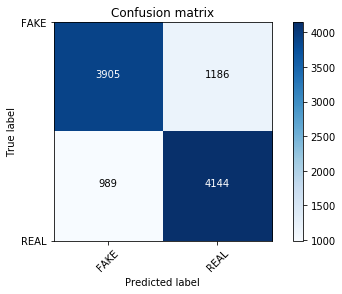

In [43]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [43]:
clf_RFC_pos = RandomForestClassifier()
clf_RFC_pos.fit(tfidf_train, y_train)
pickle.dump(clf_RFC_pos, open('pos_rf', 'wb'))
pred = clf_RFC_pos.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

C:\Users\ojas\Anaconda3\Lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with RandomForestClassifier:   0.870


Confusion matrix


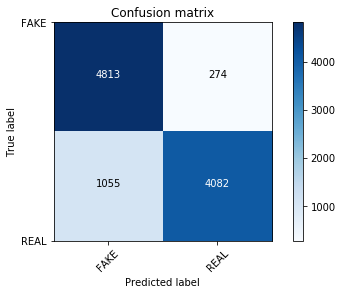

In [44]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [45]:
clf_GBC_pos = GradientBoostingClassifier()
clf_GBC_pos.fit(tfidf_train, y_train)
pickle.dump(clf_GBC_pos, open('pos_gb', 'wb'))
pred = clf_GBC_pos.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Accuracy with Gradient Boosting:   0.880


Confusion matrix


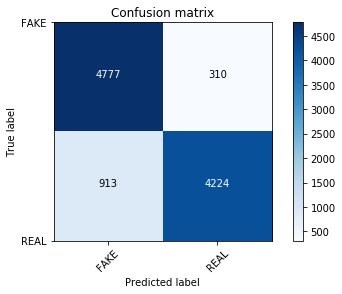

In [46]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [47]:
clf_svm_pos = svm.SVC(kernel='linear')
clf_svm_pos.fit(tfidf_train, y_train)
pickle.dump(clf_svm_pos, open('pos_svc', 'wb'))
pred = clf_svm_pos.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with SVC:   %0.3f" % score)

Accuracy with SVC:   0.836


Confusion matrix


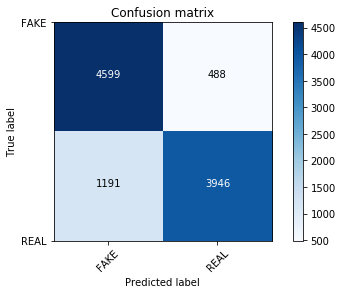

In [48]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

RandomForestClassifier
________________________________________________________________________________
Training: RandomForestClassifier


C:\Users\ojas\Anaconda3\Lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 7.188s
test time:  0.043s
accuracy:   0.868

Naive Bayes
________________________________________________________________________________
Training: Naive Bayes
train time: 0.130s
test time:  0.012s
accuracy:   0.795

GradientBoosting
________________________________________________________________________________
Training: GradientBoosting
train time: 114.911s
test time:  0.042s
accuracy:   0.880

SVC
________________________________________________________________________________
Training: SVC
train time: 248.897s
test time:  103.520s
accuracy:   0.836



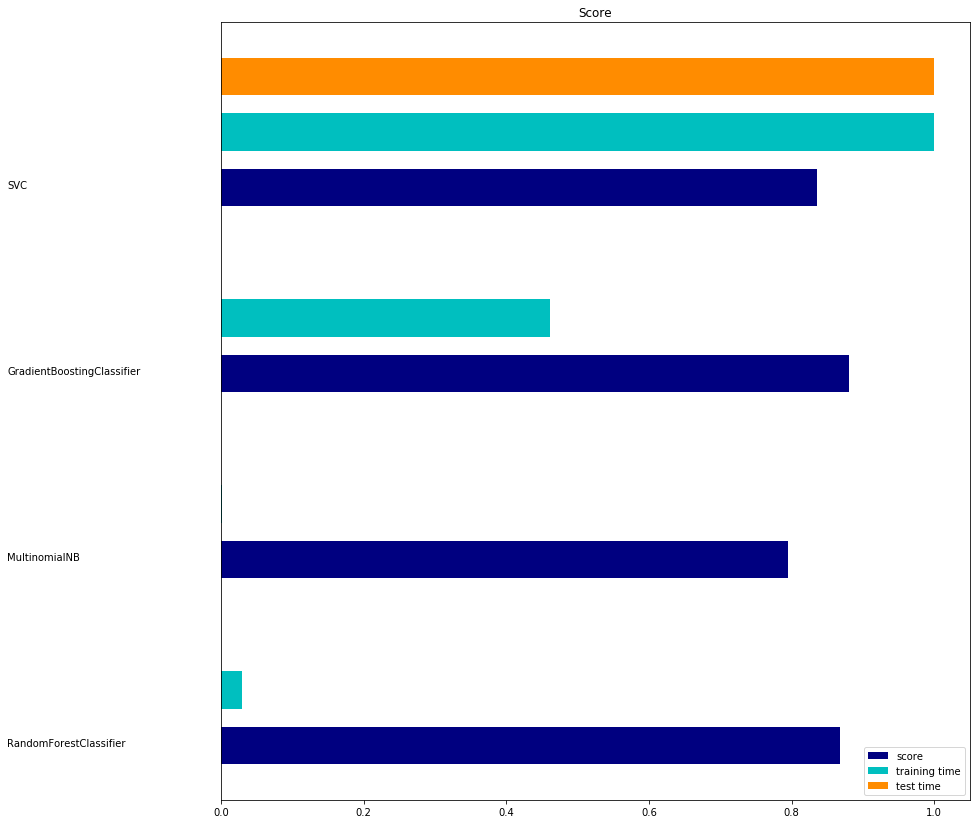

In [49]:
import logging
import sys
from time import time
def benchmark(clf,name):
    print('_' * 80)
    print("Training: "+name)
    t0 = time()
    clf.fit(tfidf_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(tfidf_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []

# Train Random Forest Classifier
print('=' * 80)
print("RandomForestClassifier")
results.append(benchmark(RandomForestClassifier(),"RandomForestClassifier"))

# Train Naive Bayes classifier
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(),"Naive Bayes"))

# Train GradientBoosting Classifier
print('=' * 80)
print("GradientBoosting")
results.append(benchmark(GradientBoostingClassifier(),"GradientBoosting"))

# Train SVC Classifier
print('=' * 80)
print("SVC")
results.append(benchmark(svm.SVC(kernel='linear'),"SVC"))

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(16, 12))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

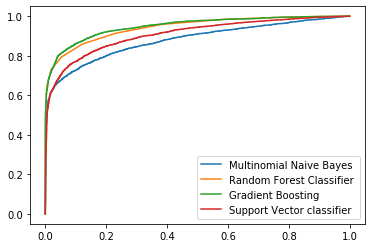

In [51]:
plt.figure(0).clf()
for model, name in [(clf_MNB_pos, 'Multinomial Naive Bayes '),
                    (clf_RFC_pos,'Random Forest Classifier'),(clf_GBC_pos,'Gradient Boosting'),(clf_svm_pos, 'Support Vector classifier')
                     ]:
    if name == 'Support Vector classifier':
        pred = model.decision_function(tfidf_test)
    else:
        pred = model.predict_proba(tfidf_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred, pos_label='REAL')
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)

In [59]:
# #Predicting using SVM using POS tagging.
# st = pd.Series(["Kayne West wins presidential elections."])
# my_headline = tfidf_vectorizer.transform(st.astype('str'))
# my_pred = clf.predict(my_headline)
# print(my_pred)

In [54]:
#Merging the 2 analysis done above.

tfidf_train_wt = tfidf_train
tfidf_test_wt = tfidf_test
tfidf1_train_wt = tfidf1_train
tfidf1_test_wt = tfidf1_test

#dif_row_tr is difference between no. of rows in syntax vector taining set and bigram vector training set.
dif_rows_tr = tfidf_train_wt.shape[0] - tfidf1_train_wt.shape[0]
X_ = sp.vstack((tfidf1_train_wt, sp.csr_matrix((dif_rows_tr, tfidf1_train_wt.shape[1]))))

# merging the syntax vector taining set(POS tagging) and bigram vector(TF-IDF bigrams) training set.
X_tr = sp.hstack((tfidf_train_wt, X_))

#dif_row_ts is difference between no. of rows in syntax vector test set and bigram vector test set.
dif_rows_ts = tfidf_test_wt.shape[0] - tfidf1_test_wt.shape[0]

Y_ = sp.vstack((tfidf1_test_wt, sp.csr_matrix((dif_rows_ts, tfidf1_test_wt.shape[1])))) 

# merging the POS tagging test set and TF-IDF test set.
X_ts = sp.hstack((tfidf_test_wt, Y_))

# print(X.get_shape())
# print(X_.get_shape())
# print(tfidf_train.get_shape())
# print(tfidf1_train.get_shape())
# print(dif_rows_tr)

In [55]:
clf_MNB_tp = MultinomialNB()
clf_MNB_tp.fit(X_tr, y_train)
pickle.dump(clf_MNB_tp, open('tp_nb', 'wb'))
pred = clf_MNB_tp.predict(X_ts)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.543


Confusion matrix


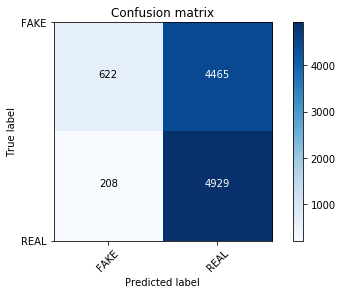

In [56]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [57]:
clf_RFC_tp = RandomForestClassifier()
clf_RFC_tp.fit(X_tr, y_train)
pickle.dump(clf_RFC_tp, open('tp_rf', 'wb'))
pred = clf_RFC_tp.predict(X_ts)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

C:\Users\ojas\Anaconda3\Lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with RandomForestClassifier:   0.739


Confusion matrix


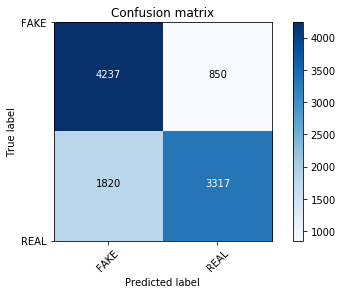

In [58]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [60]:
clf_GBC_tp = GradientBoostingClassifier()
clf_GBC_tp.fit(X_tr, y_train)
pickle.dump(clf_GBC_tp, open('tp_gb', 'wb'))
pred = clf_GBC_tp.predict(X_ts)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Accuracy with Gradient Boosting:   0.879


Confusion matrix


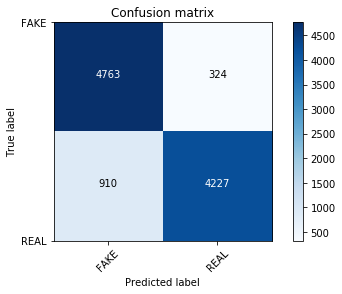

In [61]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [62]:
clf_svm_tp = svm.SVC(kernel='linear')
clf_svm_tp.fit(X_tr, y_train)
pickle.dump(clf_svm_tp, open('tp_svc', 'wb'))
pred = clf_svm_tp.predict(X_ts)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with SVC:   %0.3f" % score)

Accuracy with SVC:   0.829


Confusion matrix


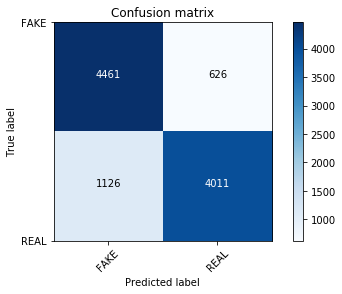

In [63]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

RandomForestClassifier
________________________________________________________________________________
Training: RandomForestClassifier


C:\Users\ojas\Anaconda3\Lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 86.409s
test time:  0.981s
accuracy:   0.761

Naive Bayes
________________________________________________________________________________
Training: Naive Bayes
train time: 1.399s
test time:  0.229s
accuracy:   0.543

GradientBoosting
________________________________________________________________________________
Training: GradientBoosting
train time: 1169.017s
test time:  0.312s
accuracy:   0.881

SVC
________________________________________________________________________________
Training: SVC
train time: 3315.800s
test time:  417.758s
accuracy:   0.829



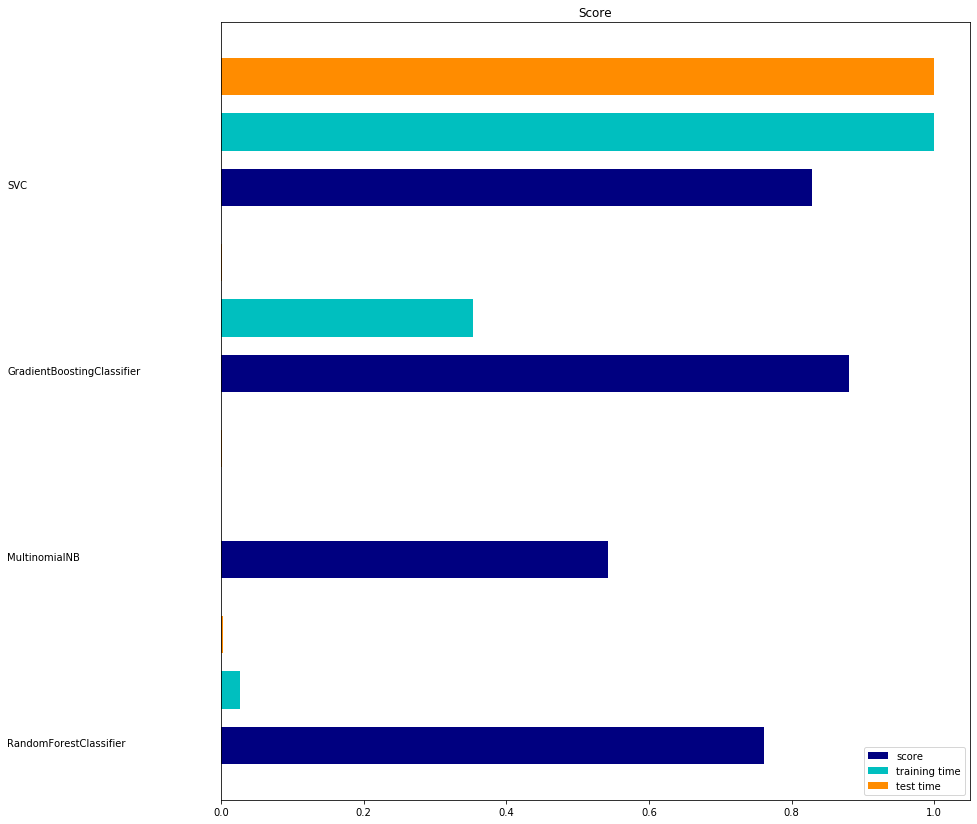

In [65]:
import logging
import sys
from time import time
def benchmark(clf,name):
    print('_' * 80)
    print("Training: "+name)
    t0 = time()
    clf.fit(X_tr, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_ts)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []

# Train Random Forest Classifier
print('=' * 80)
print("RandomForestClassifier")
results.append(benchmark(RandomForestClassifier(),"RandomForestClassifier"))

# Train Naive Bayes classifier
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(),"Naive Bayes"))

# Train GradientBoosting Classifier
print('=' * 80)
print("GradientBoosting")
results.append(benchmark(GradientBoostingClassifier(),"GradientBoosting"))

# Train SVC Classifier
print('=' * 80)
print("SVC")
results.append(benchmark(svm.SVC(kernel='linear'),"SVC"))

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(16, 12))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

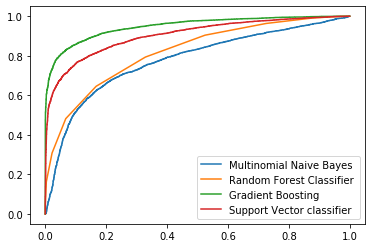

In [66]:
plt.figure(0).clf()

for model, name in [(clf_MNB_tp, 'Multinomial Naive Bayes '),
                    (clf_RFC_tp,'Random Forest Classifier'),(clf_GBC_tp,'Gradient Boosting'),(clf_svm_tp, 'Support Vector classifier')
                     ]:
    if name == 'Support Vector classifier':
        pred = model.decision_function(X_ts)
    else:
        pred = model.predict_proba(X_ts)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test.values, pred, pos_label='REAL')
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)